In [1]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from scipy import stats, linalg
import math
import matplotlib.gridspec as gridspec
import scipy

pd.set_option('float_format', '{:f}'.format)

'''
Use global variable LABEL to specify which scenario shall be considered.
Scenario 1.: "Prog1_beste"
Scenario 1a.: "Prog1_scaled"
Scenario 2.: "MfI1_beste"
Scenario 3.: "beste"
Scenario 4.: "Prog1_bestanden"
Scenario 5.: "MfI1_bestanden"
Scenario 6.: "beste_bestanden"
Scenario 7.: "beide"
'''

LABEL = "Prog1_scaled"


NOTEN = True
def load_data():
    """Loads the dataset.
    
    Returns
    -------
    DataFrame
        the dataset as DataFrame
    """
    if LABEL == "Prog1_scaled":
        data = pd.read_csv("fragebogen/stund_inf.csv").query('%s != 600'%(LABEL)).query('Prog1_beste != 600').query('%s == %s'%(LABEL,LABEL))
    else:
        data = pd.read_csv("fragebogen/stund_inf.csv").query('%s != 600'%(LABEL)).query('%s == %s'%(LABEL,LABEL))
    del data["Note_MfI1_20182_T01"]
    del data["Note_MfI1_20182_T02"]
    del data["Note_Prog1_20182_T01"]
    del data["Note_Prog1_20182_T02"]

    if LABEL != "MfI1_beste" and LABEL != "MfI1_bestanden" and LABEL != "beide":
        del data["Std_Inf"]    
    return data

def correlation_ci(r,n):
    """Calculates approximation of 95% confidence interval around given correlation using Fisher transformation.

    Parameters
    ----------
    r : float
        Correlation coefficient
    n : int
        Number of samples
        
    Returns
    -------
    list[float] 
        Lower and upper bound of confidence interval
    """
    
    stderr = 1.0 / math.sqrt(n - 3)
    delta = 1.96 * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return [lower, upper]

def display_sp(dataset, columns):
    """Shows a representation of Spearman correlation matrix, corresponding p-values and confidence intervals.
    
    Parameters
    ----------
    dataset : DataFrame
        The dataset
    columns : list[str]
        List of Strings containing the names of attributes to consider
        
    Returns
    -------
    (numpy.ndarray,numpy.ndarray,numpy.ndarray)
        Correlation matrix, p-values, bounds of confidence intervals
    """
    
    corr_matrix, pvalues = stats.spearmanr(dataset["%s"%(LABEL)],dataset[columns] )
    #Create plot for correlation matrix
    gs = gridspec.GridSpec(2, 2)
    plt.figure(figsize=(15, 15))
    plt.subplot(gs[0,0])
    columns.insert(0, "%s"%(LABEL))
    ax = sns.heatmap(corr_matrix,yticklabels=columns,xticklabels=columns,
                    vmax=1, square=True, annot=True, cmap='cubehelix')
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        horizontalalignment='right'
    );
    #Create plot for p-values
    plt.subplot(gs[1,0])
    ax2 = sns.heatmap(pvalues,yticklabels=columns,xticklabels=columns,
                    vmax=1, square=True, annot=True, cmap='cubehelix')
    ax2.set_xticklabels(
        ax2.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    ax2.set_yticklabels(
        ax2.get_yticklabels(),
        rotation=0,
        horizontalalignment='right'
    );
    #Calculate confidence intervals
    n = len(dataset.index)
    f = np.vectorize(correlation_ci)
    dim = corr_matrix.shape[0]
    intervals = np.ones((dim,dim), dtype=(float,2))
    for i in range(dim):
        for j in range(dim):
            if i != j:
                intervals[i,j] = correlation_ci(corr_matrix[i,j],n)
                
    #Create plot for confidence intervals
    plt.subplot(gs[1,1])
    ax3 = sns.heatmap(intervals[0],yticklabels=columns,xticklabels=['von','bis'],
                    vmax=1, square=True, annot=True, cmap='cubehelix')
    ax3.set_xticklabels(
        ax3.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    ax3.set_yticklabels(
        ax3.get_yticklabels(),
        rotation=0,
        horizontalalignment='right'
    );
    ax.title.set_text('Rangkorrelationen\n')
    #Set top and bottom limits manually because matplotlib 3.1.1 broke seaborn heatmaps
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax2.title.set_text('p-Werte\n')
    bottom, top = ax2.get_ylim()
    ax2.set_ylim(bottom + 0.5, top - 0.5)
    ax3.title.set_text('95%-Konfidenzintervalle\n')
    bottom, top = ax3.get_ylim()
    ax3.set_ylim(bottom + 0.5, top - 0.5)
    return corr_matrix, pvalues, intervals


def ci_list(corr_list,n):
    """Calculates 95% confidence intervals for a list of correlation coefficients.

    Parameters
    ----------
    corr_list : list[float]
        List of correlatino coefficients
    n : int
        Number of samples
        
    Returns
    -------
    numpy.ndarray
        Lower and upper bounds of confidence intervals
    """
    
    dim = corr_list.shape[0]
    intervals = np.ones(dim, dtype=(float,2))
    for i in range(dim):
        if i != 0:
            intervals[i] = correlation_ci(corr_list[i],n)
    return intervals




scipy.__version__
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


In [2]:
#Load data
data_raw = load_data()
data = data_raw
n = len(data.index)
data.tail()


,AbiBL,AbiLand,Abinote,BFI_K_1,BFI_K_11,BFI_K_12,BFI_K_13,BFI_K_14,BFI_K_16,BFI_K_17,BFI_K_18,BFI_K_19,BFI_K_2,BFI_K_3,BFI_K_4,BFI_K_6,BFI_K_7,BFI_K_8,BFI_K_9,BM_Inf_1,BM_Inf_10,BM_Inf_14,BM_Inf_15,BM_Inf_17,BM_Inf_18,BM_Inf_2,BM_Inf_3,BM_Inf_4,BM_Inf_6,BM_Inf_8,BM_Inf_9,GK_Inf,Ktyp_exp,Ktyp_psych,Kurs_Inf,LK_Inf,LK_Mat,LK_Phy,LMI_1,LMI_10,LMI_11,LMI_12,LMI_13,LMI_14,LMI_15,LMI_16,LMI_17,LMI_18,LMI_19,LMI_2,LMI_20,LMI_21,LMI_22,LMI_23,LMI_24,LMI_25,LMI_26,LMI_27,LMI_28,LMI_29,LMI_3,LMI_30,LMI_4,LMI_5,LMI_6,LMI_7,LMI_8,LMI_9,MfI1_beste,Prog1_beste,beste,MfI1_bestanden,Prog1_bestanden,beste_bestanden,beide,Prog1_scaled,SKInf_1,SKInf_2,SKInf_3,SKInf_4,SKMat_1,SKMat_2,SKMat_3,SKMat_4,Semester,Xp1,Xp2,Xp3,Xt1,Xt2,Xt3,Xtt3,mean_BFI_K_E,mean_BFI_K_G,mean_BFI_K_N,mean_BFI_K_V,mean_LMI,mean_SKInf,mean_SKMat,sex,stg_Bioinf,stg_CKT,stg_Cyber,stg_ES,stg_Inf,stg_InfNeben,stg_MathInf,stg_Medieninf
272,11,1,2.800000,2,4,5,4,2,4,5,3,2,5,4,1,4,5,5,2,4,4,3,3,4,4,4,4,3,4,2,4,1,14,10,5.000000,2,1,2,7,5,6,4,6,6,7,5,5,6,4,6,5,4,4,7,2,5,6,6,5,5,3,5,2,6,5,7,6,5,nan,500,500,nan,1,1,nan,500.000000,7,7,7,7,5,5,5,5,nan,2.000000,1.000000,3.000000,2.000000,3.000000,2.000000,nan,3.500000,4.000000,1.750000,5.000000,5.166667,7.000000,5.000000,2,nan,nan,nan,nan,nan,nan,nan,nan
273,11,1,1.800000,4,1,2,4,2,4,2,5,1,3,4,1,5,2,2,3,4,4,4,4,2,2,4,3,3,4,3,3,2,10,14,3.000000,1,1,1,7,6,6,5,6,6,6,5,5,7,5,7,4,6,6,6,5,7,6,5,5,5,3,4,5,6,5,6,5,6,nan,330,330,nan,0,0,nan,330.000000,6,7,6,5,5,6,6,4,nan,2.000000,3.000000,1.000000,2.000000,1.000000,0.000000,nan,3.500000,3.750000,1.750000,2.250000,5.533333,6.000000,5.250000,2,nan,nan,nan,nan,nan,nan,nan,nan
274,11,1,1.400000,5,1,1,5,4,5,2,5,1,2,5,1,5,4,4,4,4,4,2,2,1,1,4,4,4,4,1,4,1,2,2,2.000000,2,1,1,6,4,7,6,7,6,7,7,6,7,6,7,7,7,7,7,7,7,6,5,7,7,2,7,6,7,6,7,7,7,nan,500,500,nan,1,1,nan,500.000000,6,6,3,6,7,7,6,6,nan,0.000000,1.000000,1.000000,0.000000,1.000000,2.000000,nan,4.000000,4.750000,2.500000,2.250000,6.400000,5.250000,6.500000,1,nan,nan,nan,nan,nan,nan,nan,nan
275,16,1,2.500000,2,3,2,4,4,2,4,4,4,3,4,2,3,3,3,2,3,4,2,2,1,2,3,4,4,4,2,3,2,16,16,4.000000,2,1,1,6,6,3,7,7,6,7,6,7,5,4,5,6,6,6,3,5,5,5,4,5,6,5,7,4,7,5,2,6,5,nan,130,130,nan,0,0,nan,130.000000,4,5,2,5,6,6,5,5,nan,3.000000,2.000000,2.000000,3.000000,2.000000,nan,1.000000,2.500000,3.750000,3.000000,3.000000,5.366667,4.000000,5.500000,2,nan,nan,nan,nan,nan,nan,nan,nan
276,6,1,1.600000,4,2,4,4,4,5,5,4,3,4,4,3,4,4,2,1,3,3,4,4,1,2,3,4,4,4,3,3,2,10,14,0.000000,2,1,2,7,6,5,6,6,5,7,6,5,6,5,5,6,6,5,7,5,6,5,6,5,5,4,6,5,7,5,6,5,5,nan,300,300,nan,0,0,nan,300.000000,4,4,1,4,4,5,4,4,nan,2.000000,3.000000,1.000000,2.000000,1.000000,0.000000,nan,3.750000,3.500000,2.750000,4.250000,5.600000,3.250000,4.250000,2,nan,nan,nan,nan,nan,nan,nan,nan


In [3]:
#Choose only appropriate columns for Spearman Correlation (e.g. at least ordinal)
ordinal_columns = ["%s"%(LABEL),"Abinote","SKMat_1","SKMat_2","SKMat_3","SKMat_4", "mean_SKMat",
              "SKInf_1","SKInf_2","SKInf_3","SKInf_4", "mean_SKInf",
              "BM_Inf_1","BM_Inf_2","BM_Inf_3","BM_Inf_4","BM_Inf_6","BM_Inf_8","BM_Inf_9","BM_Inf_10",
              "BM_Inf_14","BM_Inf_15","BM_Inf_17","BM_Inf_18",
              "BFI_K_1","BFI_K_2","BFI_K_3","BFI_K_4","BFI_K_6","BFI_K_7","BFI_K_8","BFI_K_9","BFI_K_11",
              "BFI_K_12","BFI_K_13","BFI_K_14","BFI_K_16","BFI_K_17","BFI_K_18","BFI_K_19",
              "mean_BFI_K_N", "mean_BFI_K_G", "mean_BFI_K_V", "mean_BFI_K_E",
              "LMI_1","LMI_2","LMI_3","LMI_4","LMI_5","LMI_6","LMI_7","LMI_8","LMI_9","LMI_10","LMI_11","LMI_12",
              "LMI_13","LMI_14","LMI_15","LMI_16","LMI_17","LMI_18","LMI_19","LMI_20","LMI_21","LMI_22","LMI_23",
              "LMI_24","LMI_25","LMI_26","LMI_27","LMI_28","LMI_29","LMI_30", "mean_LMI",
              "Ktyp_psych", "Ktyp_exp",
              "Kurs_Inf"]
#Use this list to calculate correlations with Std_Inf in appropriate cases/scenarios
std_column = ["%s"%(LABEL), "Std_Inf"]

In [4]:
#Create correlation matrix of all possible attributes
corr_matrix = data[ordinal_columns].corr(method="spearman")
#Sort the correlations with label in descending order (absolute value) 
if(LABEL == "Prog1_beste"):
    corr_list = corr_matrix["Prog1_beste"].iloc[corr_matrix.Prog1_beste.abs().argsort()[::-1]]   
elif(LABEL == "MfI1_beste"):
    corr_list = corr_matrix["MfI1_beste"].iloc[corr_matrix.MfI1_beste.abs().argsort()[::-1]]
elif(LABEL == "beste"):
    corr_list = corr_matrix["beste"].iloc[corr_matrix.beste.abs().argsort()[::-1]]
elif(LABEL == "Prog1_bestanden"):
    corr_list = corr_matrix["Prog1_bestanden"].iloc[corr_matrix.Prog1_bestanden.abs().argsort()[::-1]]
elif(LABEL == "MfI1_bestanden"):
    corr_list = corr_matrix["MfI1_bestanden"].iloc[corr_matrix.MfI1_bestanden.abs().argsort()[::-1]]
elif(LABEL == "beste_bestanden"):
    corr_list = corr_matrix["beste_bestanden"].iloc[corr_matrix.beste_bestanden.abs().argsort()[::-1]]
elif(LABEL == "Prog1_scaled"):
    corr_list = corr_matrix["Prog1_scaled"].iloc[corr_matrix.Prog1_scaled.abs().argsort()[::-1]]  
else:
    corr_list = corr_matrix["beide"].iloc[corr_matrix.beide.abs().argsort()[::-1]]

#Calculate and print confidence intervals
ci = ci_list(corr_list,n)
corr_df = pd.DataFrame({'Korrelationen':corr_list, 'untere Grenze': ci[:,0], 'obere Grenze': ci[:,1]})
print(corr_df)


              Korrelationen  untere Grenze  obere Grenze
Prog1_scaled       1.000000       1.000000      1.000000
Abinote            0.504869       0.410953      0.588181
SKMat_1           -0.361526      -0.460308     -0.253902
mean_SKMat        -0.348979      -0.448916     -0.240419
SKMat_2           -0.308010      -0.411492     -0.196687
SKMat_3           -0.294872      -0.399418     -0.182756
SKMat_4           -0.269831      -0.376300     -0.156327
Ktyp_exp          -0.251988      -0.359748     -0.137595
SKInf_1           -0.245781      -0.353973     -0.131097
BFI_K_3           -0.238009      -0.346731     -0.122975
mean_BFI_K_G      -0.223956      -0.333604     -0.108328
BM_Inf_17         -0.207118      -0.317819     -0.090846
Ktyp_psych        -0.197002      -0.308306     -0.080376
LMI_3             -0.196518      -0.307851     -0.079876
BFI_K_8           -0.194822      -0.306253     -0.078123
BFI_K_13          -0.191081      -0.302729     -0.074261
BM_Inf_18         -0.184897    

Persönlichkeitswerte: 



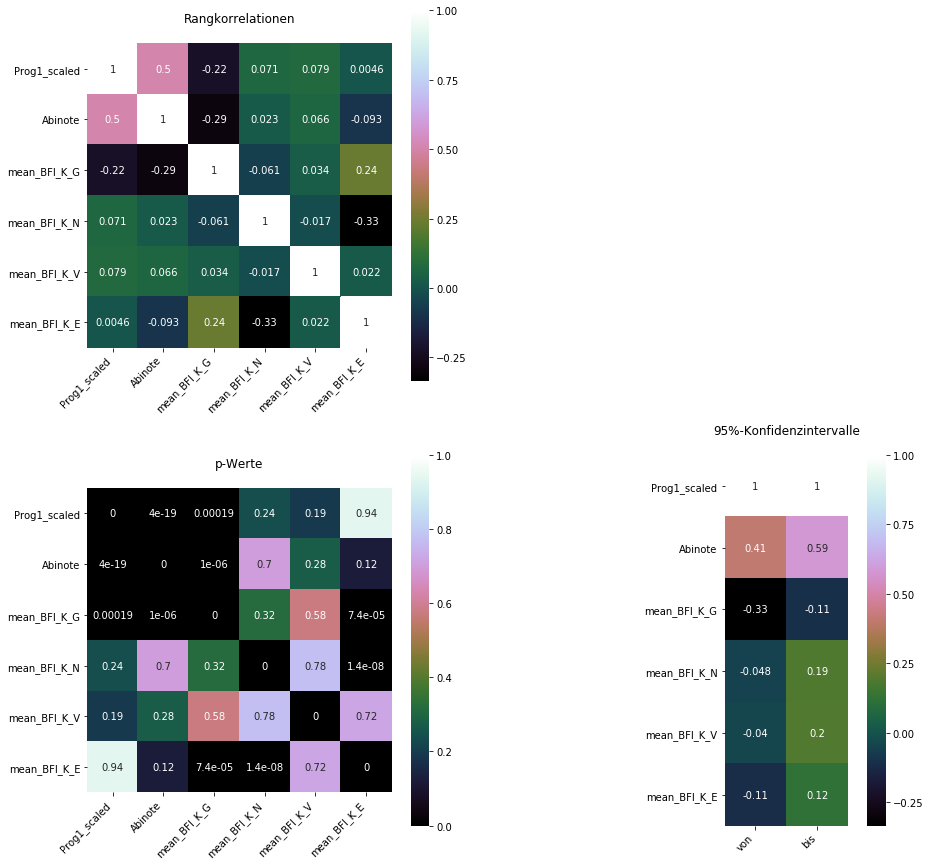

In [5]:
print("Persönlichkeitswerte: \n")
columns = ["Abinote", "mean_BFI_K_G", "mean_BFI_K_N", "mean_BFI_K_V", "mean_BFI_K_E"]
corr_matrix, pvalues, intervals = display_sp(data,columns)


LMI: 



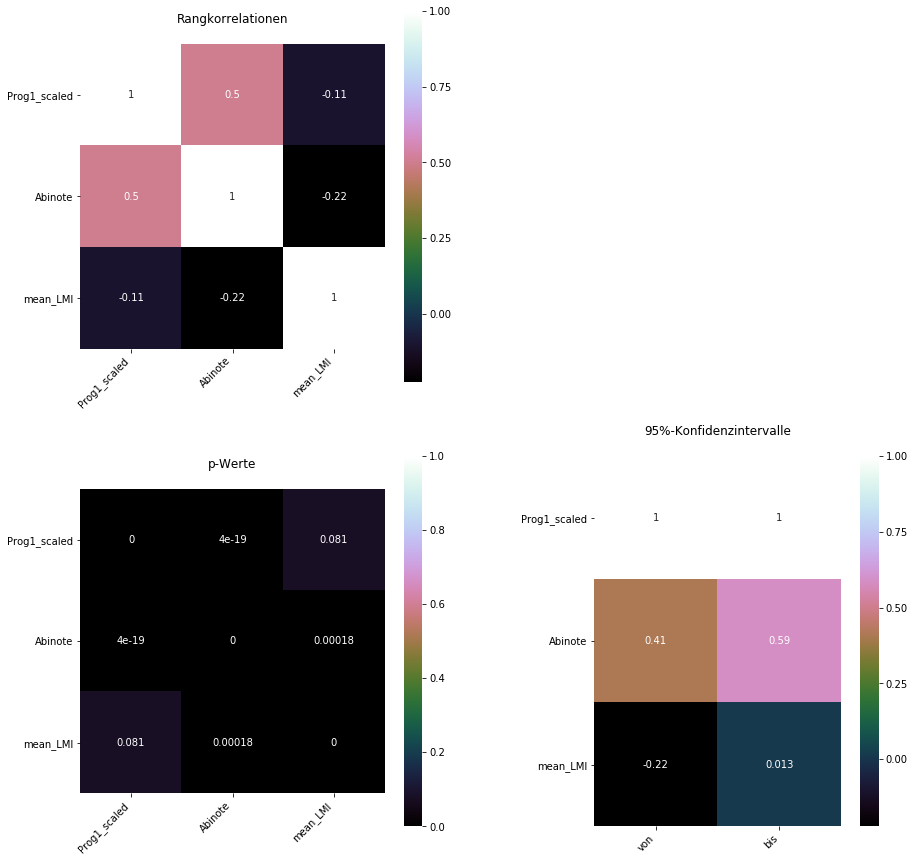

In [6]:
print("LMI: \n")
columns = ["Abinote", "mean_LMI"]
corr_matrix, pvalues, intervals = display_sp(data,columns)

SK: 



(array([[ 1.        , -0.17397503, -0.34897853],
        [-0.17397503,  1.        ,  0.24171973],
        [-0.34897853,  0.24171973,  1.        ]]),
 array([[0.00000000e+00, 3.86844222e-03, 2.88629052e-09],
        [3.86844222e-03, 0.00000000e+00, 5.27726140e-05],
        [2.88629052e-09, 5.27726140e-05, 0.00000000e+00]]),
 array([[[ 1.        ,  1.        ],
         [-0.28656911, -0.05664066],
         [-0.44891585, -0.24041887]],
 
        [[-0.28656911, -0.05664066],
         [ 1.        ,  1.        ],
         [ 0.12685119,  0.35019086]],
 
        [[-0.44891585, -0.24041887],
         [ 0.12685119,  0.35019086],
         [ 1.        ,  1.        ]]]))

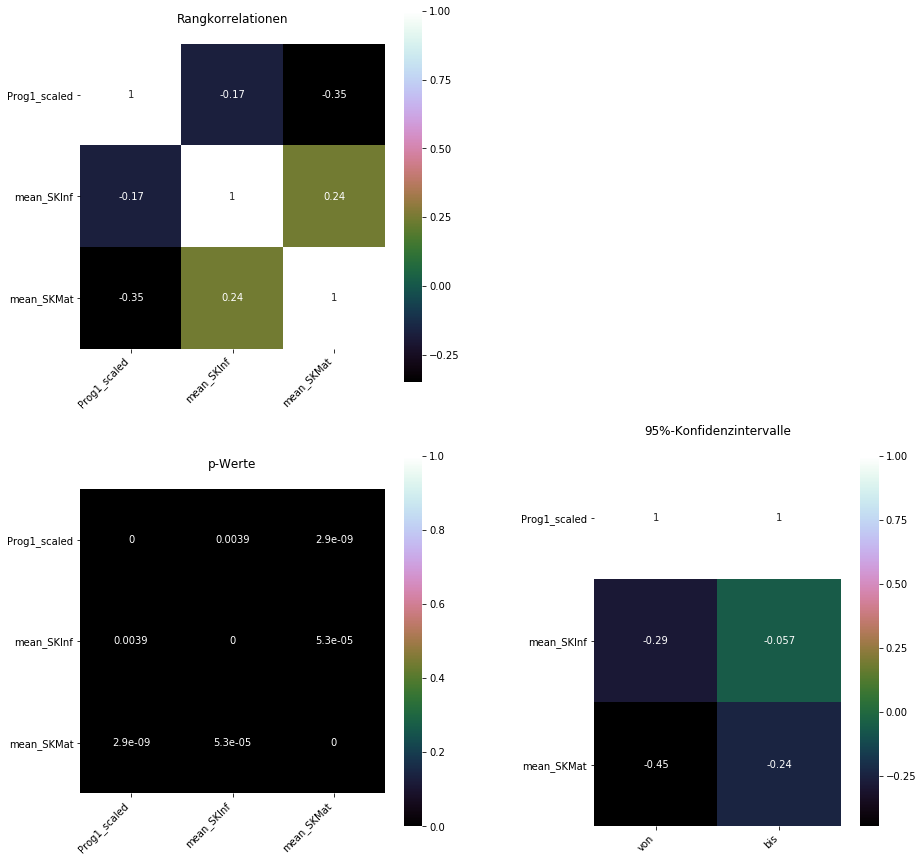

In [7]:
print("SK: \n")
columns = ["mean_SKInf", "mean_SKMat"]
display_sp(data,columns)

Kongruenz: 



(array([[ 1.        , -0.19700154, -0.2519883 ],
        [-0.19700154,  1.        ,  0.92338771],
        [-0.2519883 ,  0.92338771,  1.        ]]),
 array([[0.00000000e+000, 1.04459485e-003, 2.43888821e-005],
        [1.04459485e-003, 0.00000000e+000, 4.13307639e-115],
        [2.43888821e-005, 4.13307639e-115, 0.00000000e+000]]),
 array([[[ 1.        ,  1.        ],
         [-0.3083062 , -0.08037582],
         [-0.35974792, -0.13759494]],
 
        [[-0.3083062 , -0.08037582],
         [ 1.        ,  1.        ],
         [ 0.90378031,  0.93912733]],
 
        [[-0.35974792, -0.13759494],
         [ 0.90378031,  0.93912733],
         [ 1.        ,  1.        ]]]))

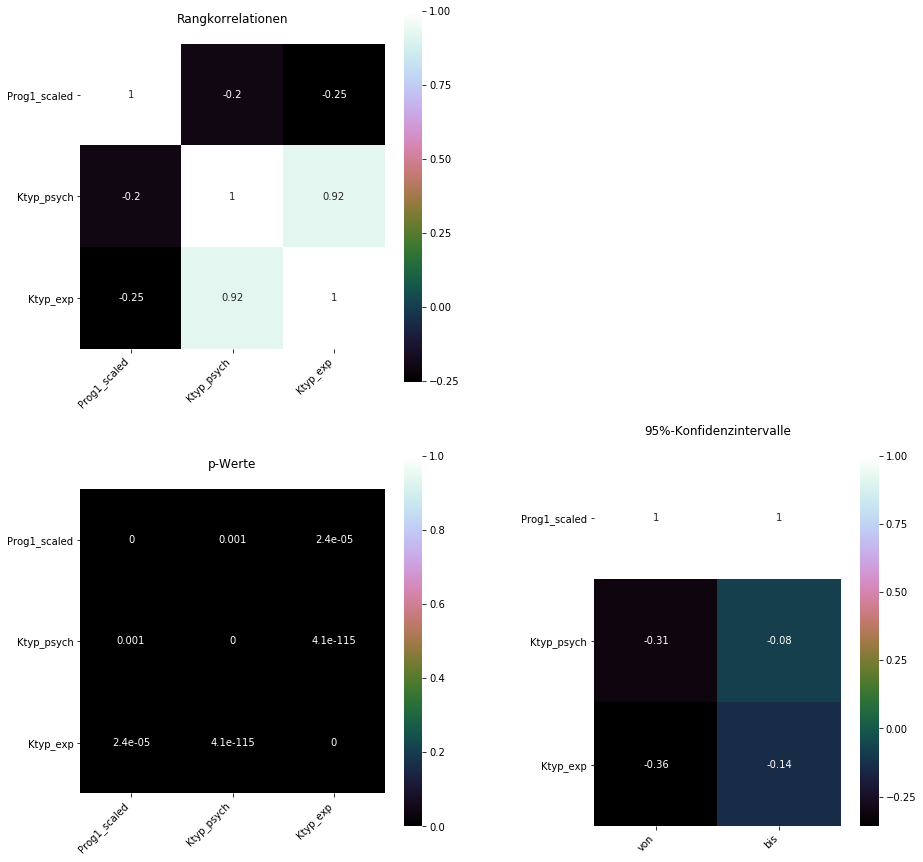

In [8]:
print("Kongruenz: \n")
columns = ["Ktyp_psych","Ktyp_exp"]
display_sp(data,columns)

In [9]:
from scipy import stats
def chi2_test(data, columns):
    """Calculate chi squared test using contingency table of SciPy package.
    
    Parameters
    ----------
    data : DataFrame
        The dataset
    columns : list[str]
        List of Strings containing the names of attributes to consider
        
    Returns
    -------
    (float,float,int,numpy.ndarray)
        The chi squared test statistic, corresponding p-value, degrees of freedom, expected frequencies
    """
    
    table = data[columns]
    num_values=len(table[columns[1]].value_counts())
    print(num_values)
    contingency_table = pd.crosstab(
        table['%s'%(LABEL)],
        table[columns[1]],
        margins = True
    )
    print(contingency_table)
    if NOTEN and (LABEL!="Prog1_scaled"):
        f_obs = np.array([contingency_table.iloc[0][0:(num_values+1)].values,
                          contingency_table.iloc[1][0:(num_values+1)].values,
                          contingency_table.iloc[2][0:(num_values+1)].values,
                          contingency_table.iloc[3][0:(num_values+1)].values,
                          contingency_table.iloc[4][0:(num_values+1)].values,
                          contingency_table.iloc[5][0:(num_values+1)].values,
                          contingency_table.iloc[6][0:(num_values+1)].values,
                          contingency_table.iloc[7][0:(num_values+1)].values,
                          contingency_table.iloc[8][0:(num_values+1)].values,
                          contingency_table.iloc[9][0:(num_values+1)].values,
                          contingency_table.iloc[10][0:(num_values+1)].values])
    elif(LABEL == "Prog1_scaled"):
        f_obs = np.array([contingency_table.iloc[0][0:(num_values+1)].values,
                          contingency_table.iloc[1][0:(num_values+1)].values,
                          contingency_table.iloc[2][0:(num_values+1)].values,
                          contingency_table.iloc[3][0:(num_values+1)].values,
                          contingency_table.iloc[4][0:(num_values+1)].values,
                          contingency_table.iloc[5][0:(num_values+1)].values,
                          contingency_table.iloc[6][0:(num_values+1)].values,
                          contingency_table.iloc[7][0:(num_values+1)].values,
                          contingency_table.iloc[8][0:(num_values+1)].values,
                          contingency_table.iloc[9][0:(num_values+1)].values,
                          contingency_table.iloc[10][0:(num_values+1)].values,
                          contingency_table.iloc[11][0:(num_values+1)].values,
                          contingency_table.iloc[12][0:(num_values+1)].values,
                          contingency_table.iloc[13][0:(num_values+1)].values,
                          contingency_table.iloc[14][0:(num_values+1)].values,
                          contingency_table.iloc[15][0:(num_values+1)].values,
                          contingency_table.iloc[16][0:(num_values+1)].values,
                          contingency_table.iloc[17][0:(num_values+1)].values,
                          contingency_table.iloc[18][0:(num_values+1)].values,
                          contingency_table.iloc[19][0:(num_values+1)].values,
                          contingency_table.iloc[20][0:(num_values+1)].values,
                          contingency_table.iloc[21][0:(num_values+1)].values])
    elif(LABEL=="beide"):
        f_obs = np.array([contingency_table.iloc[0][0:(num_values+1)].values,
                          contingency_table.iloc[1][0:(num_values+1)].values,
                          contingency_table.iloc[2][0:(num_values+1)].values,
                          contingency_table.iloc[3][0:(num_values+1)].values])
    else:
        f_obs = np.array([contingency_table.iloc[0][0:(num_values+1)].values,
                          contingency_table.iloc[1][0:(num_values+1)].values,
                          contingency_table.iloc[2][0:(num_values+1)].values])
       
    return stats.chi2_contingency(f_obs)[0:11]

print("LK_Mat: \n")
columns = ["%s"%(LABEL),"LK_Mat"]
print(chi2_test(data, columns))
print("LK_Inf: \n")
columns = ["%s"%(LABEL),"LK_Inf"]
print(chi2_test(data, columns))
print("LK_Phy: \n")
columns = ["%s"%(LABEL),"LK_Phy"]
print(chi2_test(data, columns))

print("sex: \n")
columns = ["%s"%(LABEL),"sex"]
print(chi2_test(data, columns))

print("AbiLand: \n")
columns = ["%s"%(LABEL),"AbiLand"]
print(chi2_test(data, columns))

print("AbiBL: \n")
columns = ["%s"%(LABEL),"AbiBL"]
print(chi2_test(data, columns))

print("GK_Inf: \n")
columns = ["%s"%(LABEL),"GK_Inf"]
print(chi2_test(data, columns))



LK_Mat: 

2
LK_Mat                1   2  All
Prog1_scaled                    
100.0                10   2   12
124.04302505975201   25   4   29
130.0                13   0   13
148.080043771593      6   2    8
170.0                 8   2   10
180.129402054054     13   1   14
200.0                 9   3   12
204.16642076587502    3   2    5
228.203439477715      5   1    6
230.0                 9   1   10
260.252797760176     11   2   13
270.0                 6   1    7
284.28981647199697    5   2    7
300.0                 7   3   10
308.326835183838      5   1    6
330.0                 8   3   11
340.376193466299      2   6    8
364.41321217812003    7   1    8
370.0                 4   0    4
400.0                 4   1    5
444.536607884242     30  17   47
500.0                22   7   29
All                 212  62  274
(29.783498423114736, 0.9214736372486956, 42, array([[ 9.28467153,  2.71532847, 12.        ],
       [22.4379562 ,  6.5620438 , 29.        ],
       [10.05839416,  

AbiBL                0  1  3  5   6  8   9  10   11  12  13  14  15  16  All
Prog1_scaled                                                                
100.0                2  0  0  0   1  0   2   0    5   0   1   0   0   1   12
124.04302505975201   3  4  0  0   2  1   1   4   12   0   0   1   1   0   29
130.0                0  0  0  0   1  0   0   3    6   0   0   1   0   2   13
148.080043771593     0  0  0  0   0  0   0   3    5   0   0   0   0   0    8
170.0                2  0  0  1   1  0   0   2    4   0   0   0   0   0   10
180.129402054054     0  0  0  0   0  0   0   1   13   0   0   0   0   0   14
200.0                0  0  0  0   0  0   0   4    8   0   0   0   0   0   12
204.16642076587502   0  0  0  0   0  0   0   0    3   0   0   0   0   2    5
228.203439477715     1  1  0  0   0  0   0   2    1   0   0   0   0   1    6
230.0                1  1  0  0   0  0   0   1    5   0   0   0   0   2   10
260.252797760176     1  1  0  0   0  0   0   1    8   0   0   0   0   2   13

Folgenanreiz Beruf: 



(array([[ 1.        ,  0.02549995, -0.07420522],
        [ 0.02549995,  1.        ,  0.48665435],
        [-0.07420522,  0.48665435,  1.        ]]),
 array([[0.00000000e+00, 6.74311676e-01, 2.20805792e-01],
        [6.74311676e-01, 0.00000000e+00, 1.06751744e-17],
        [2.20805792e-01, 1.06751744e-17, 0.00000000e+00]]),
 array([[[ 1.        ,  1.        ],
         [-0.09328404,  0.14356821],
         [-0.19102753,  0.04468986]],
 
        [[-0.09328404,  0.14356821],
         [ 1.        ,  1.        ],
         [ 0.39068275,  0.57216022]],
 
        [[-0.19102753,  0.04468986],
         [ 0.39068275,  0.57216022],
         [ 1.        ,  1.        ]]]))

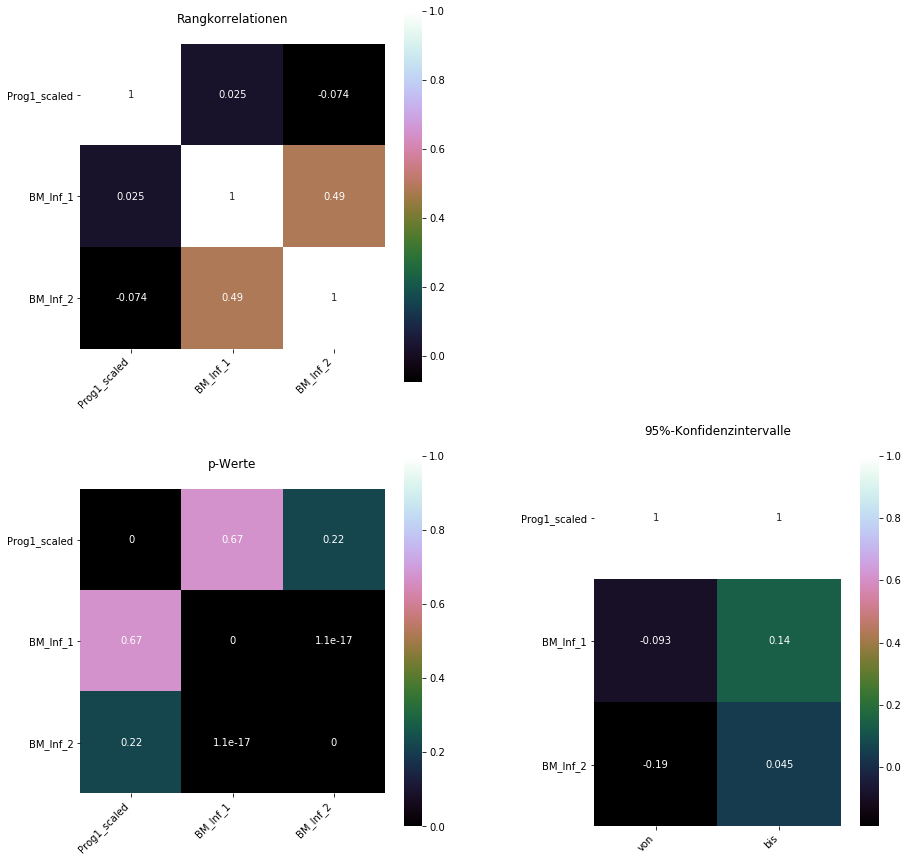

In [10]:
print("Folgenanreiz Beruf: \n")
columns = ["BM_Inf_1","BM_Inf_2"]
display_sp(data,columns)

Folgenanreiz intellektuell: 



(array([[ 1.        , -0.05471351,  0.02289888,  0.05082694],
        [-0.05471351,  1.        ,  0.46071724,  0.009251  ],
        [ 0.02289888,  0.46071724,  1.        ,  0.06750941],
        [ 0.05082694,  0.009251  ,  0.06750941,  1.        ]]),
 array([[0.00000000e+00, 3.66947767e-01, 7.05905737e-01, 4.02013220e-01],
        [3.66947767e-01, 0.00000000e+00, 8.37859976e-16, 8.78844211e-01],
        [7.05905737e-01, 8.37859976e-16, 0.00000000e+00, 2.65432925e-01],
        [4.02013220e-01, 8.78844211e-01, 2.65432925e-01, 0.00000000e+00]]),
 array([[[ 1.        ,  1.        ],
         [-0.17209978,  0.06420487],
         [-0.09586336,  0.14101831],
         [-0.06808524,  0.16831526]],
 
        [[-0.17209978,  0.06420487],
         [ 1.        ,  1.        ],
         [ 0.36197765,  0.54923341],
         [-0.109371  ,  0.12761321]],
 
        [[-0.09586336,  0.14101831],
         [ 0.36197765,  0.54923341],
         [ 1.        ,  1.        ],
         [-0.05140393,  0.18453522]],
 

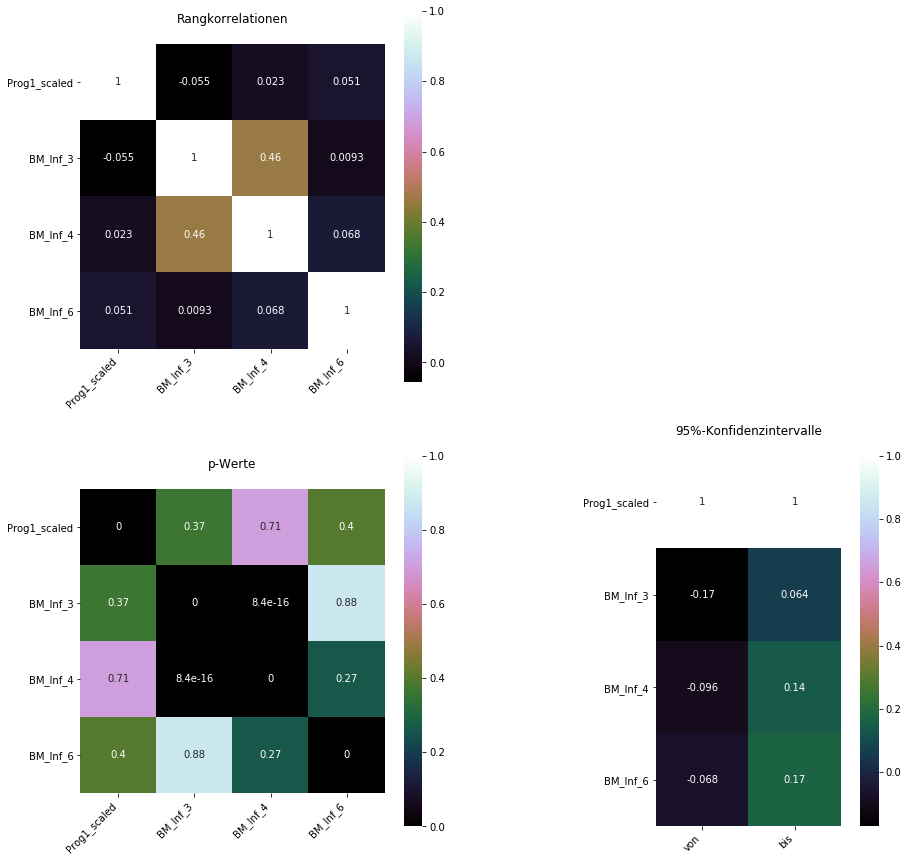

In [11]:
print("Folgenanreiz intellektuell: \n")
columns = ["BM_Inf_3","BM_Inf_4","BM_Inf_6"]
display_sp(data,columns)

Tätigkeitsanreiz: 



(array([[1.        , 0.00304656, 0.05985428],
        [0.00304656, 1.        , 0.60246528],
        [0.05985428, 0.60246528, 1.        ]]),
 array([[0.00000000e+00, 9.59963678e-01, 3.23583603e-01],
        [9.59963678e-01, 0.00000000e+00, 1.85288387e-28],
        [3.23583603e-01, 1.85288387e-28, 0.00000000e+00]]),
 array([[[ 1.        ,  1.        ],
         [-0.11549724,  0.1215048 ],
         [-0.05906678,  0.17710023]],
 
        [[-0.11549724,  0.1215048 ],
         [ 1.        ,  1.        ],
         [ 0.52117137,  0.67292497]],
 
        [[-0.05906678,  0.17710023],
         [ 0.52117137,  0.67292497],
         [ 1.        ,  1.        ]]]))

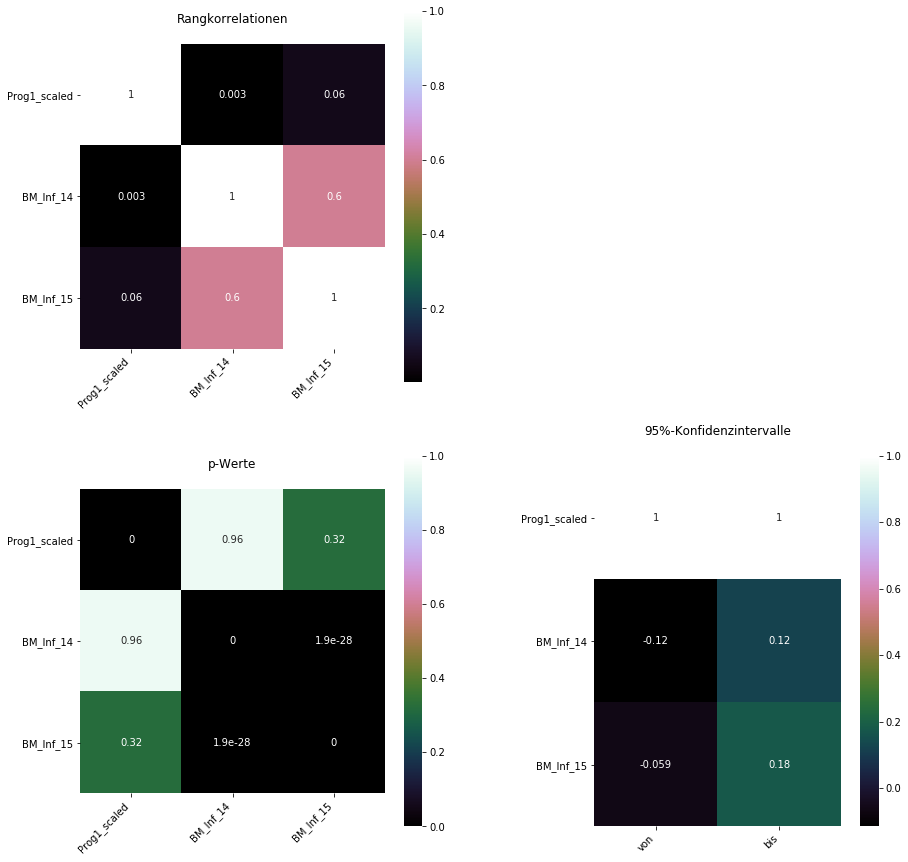

In [12]:
print("Tätigkeitsanreiz: \n")
columns = ["BM_Inf_14","BM_Inf_15"]
display_sp(data,columns)

Image: 



(array([[ 1.        ,  0.50486896, -0.02944758],
        [ 0.50486896,  1.        ,  0.02094699],
        [-0.02944758,  0.02094699,  1.        ]]),
 array([[0.00000000e+00, 3.96572963e-19, 6.27448683e-01],
        [3.96572963e-19, 0.00000000e+00, 7.29953663e-01],
        [6.27448683e-01, 7.29953663e-01, 0.00000000e+00]]),
 array([[[ 1.        ,  1.        ],
         [ 0.41095339,  0.58818133],
         [-0.14743519,  0.08936638]],
 
        [[ 0.41095339,  0.58818133],
         [ 1.        ,  1.        ],
         [-0.09779787,  0.1391038 ]],
 
        [[-0.14743519,  0.08936638],
         [-0.09779787,  0.1391038 ],
         [ 1.        ,  1.        ]]]))

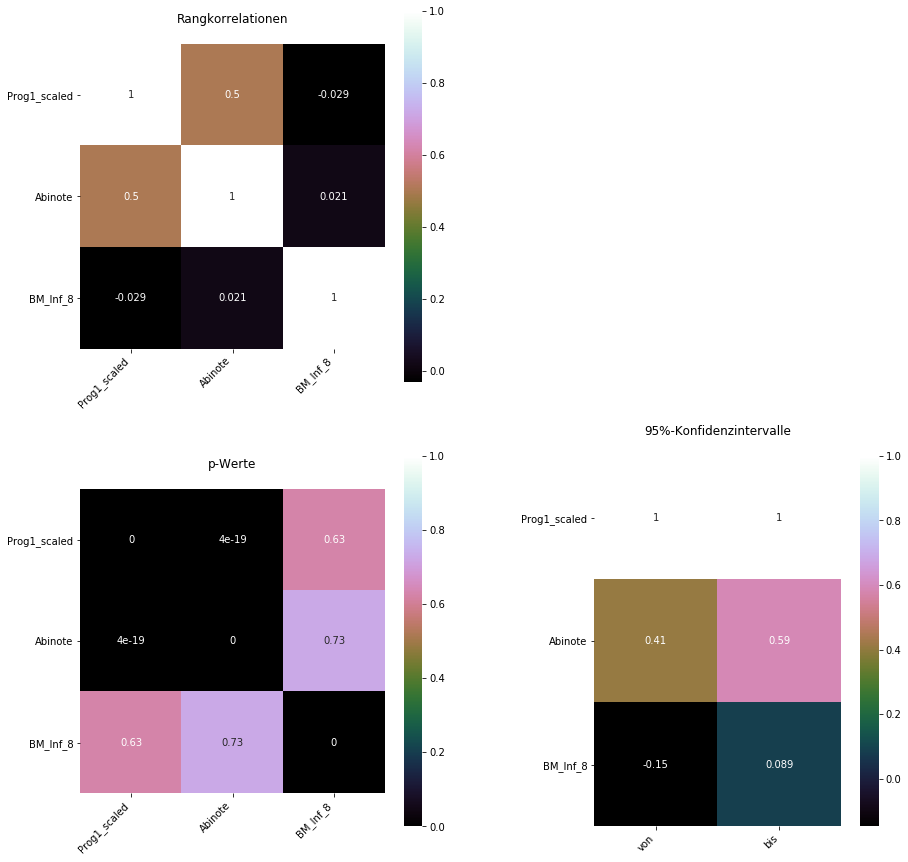

In [13]:
print("Image: \n")
columns = ["Abinote","BM_Inf_8"]
display_sp(data,columns)

berufliches Selbstkonzept: 



(array([[ 1.        , -0.12682944, -0.04080426, -0.20711791, -0.184897  ],
        [-0.12682944,  1.        ,  0.18927175,  0.26346045,  0.32203521],
        [-0.04080426,  0.18927175,  1.        ,  0.14537011,  0.19583098],
        [-0.20711791,  0.26346045,  0.14537011,  1.        ,  0.65488769],
        [-0.184897  ,  0.32203521,  0.19583098,  0.65488769,  1.        ]]),
 array([[0.00000000e+00, 3.58800940e-02, 5.01187139e-01, 5.60119296e-04,
         2.11820330e-03],
        [3.58800940e-02, 0.00000000e+00, 1.64855215e-03, 9.89587445e-06,
         4.97521518e-08],
        [5.01187139e-01, 1.64855215e-03, 0.00000000e+00, 1.60354230e-02,
         1.12055770e-03],
        [5.60119296e-04, 9.89587445e-06, 1.60354230e-02, 0.00000000e+00,
         6.04148934e-35],
        [2.11820330e-03, 4.97521518e-08, 1.12055770e-03, 6.04148934e-35,
         0.00000000e+00]]),
 array([[[ 1.        ,  1.        ],
         [-0.24169891, -0.0084544 ],
         [-0.15853976,  0.07807537],
         [-0.31

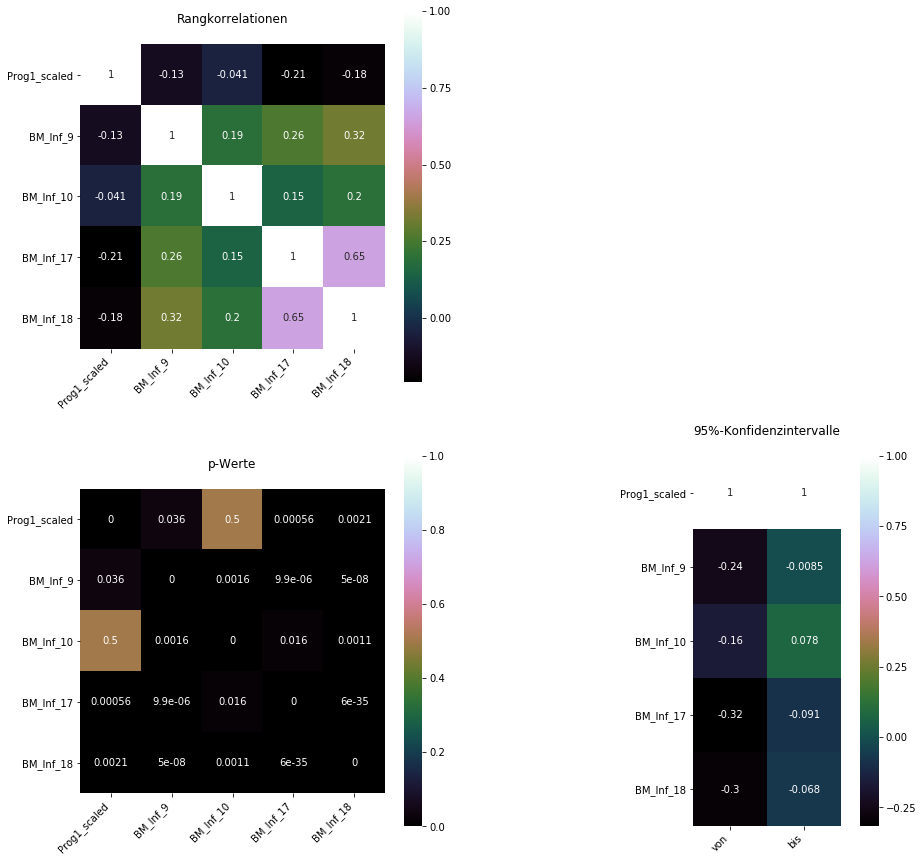

In [14]:
print("berufliches Selbstkonzept: \n")
columns = ["BM_Inf_9","BM_Inf_10","BM_Inf_17","BM_Inf_18"]
display_sp(data,columns)

Werte für besondere Attribute aus Arbeit: 



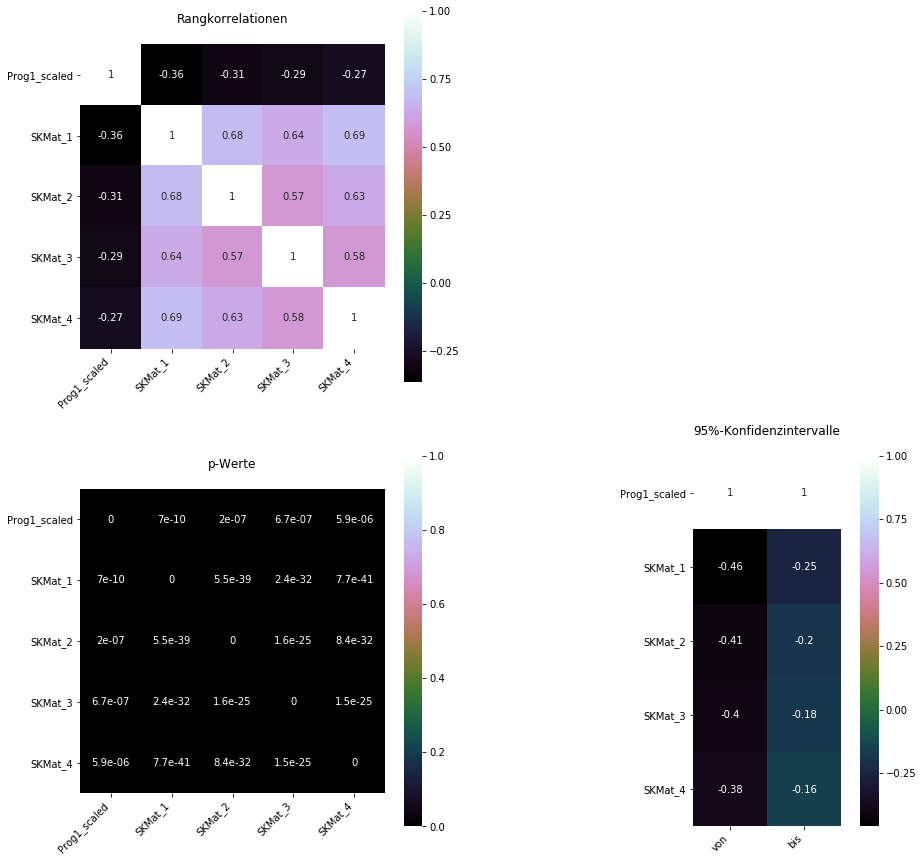

In [15]:
print("Werte für besondere Attribute aus Arbeit: \n")
columns = ["SKMat_1", "SKMat_2","SKMat_3","SKMat_4"]
corr_matrix, pvalues, intervals = display_sp(data,columns)

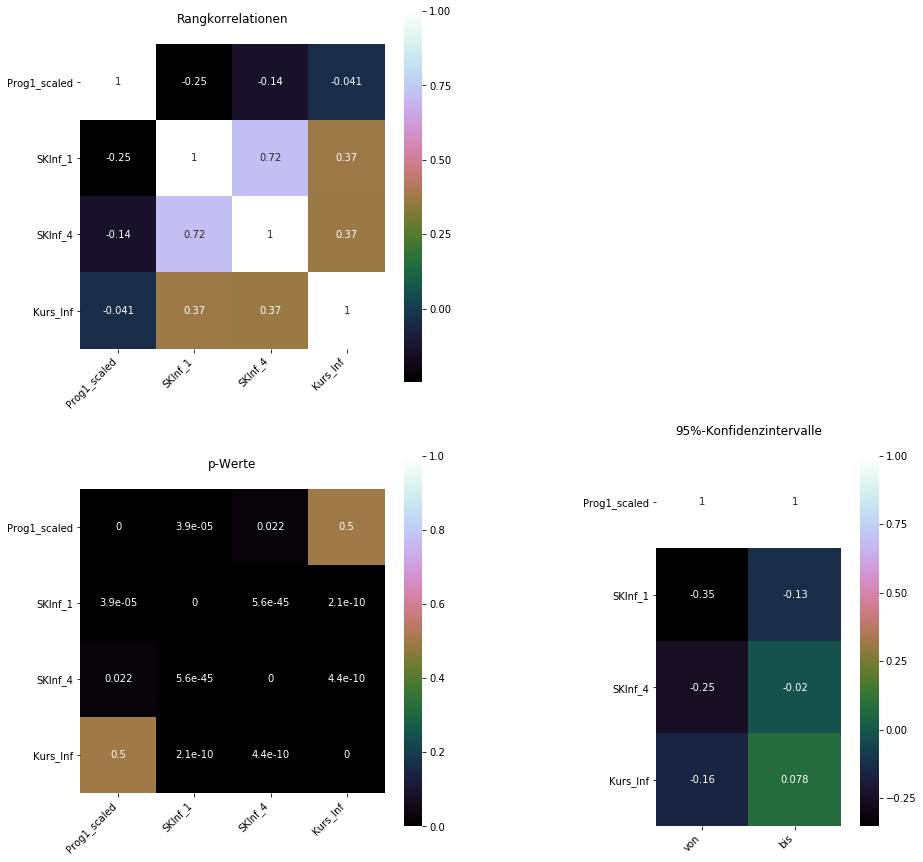

In [16]:
columns = ["SKInf_1","SKInf_4","Kurs_Inf"]
corr_matrix, pvalues, intervals = display_sp(data,columns)

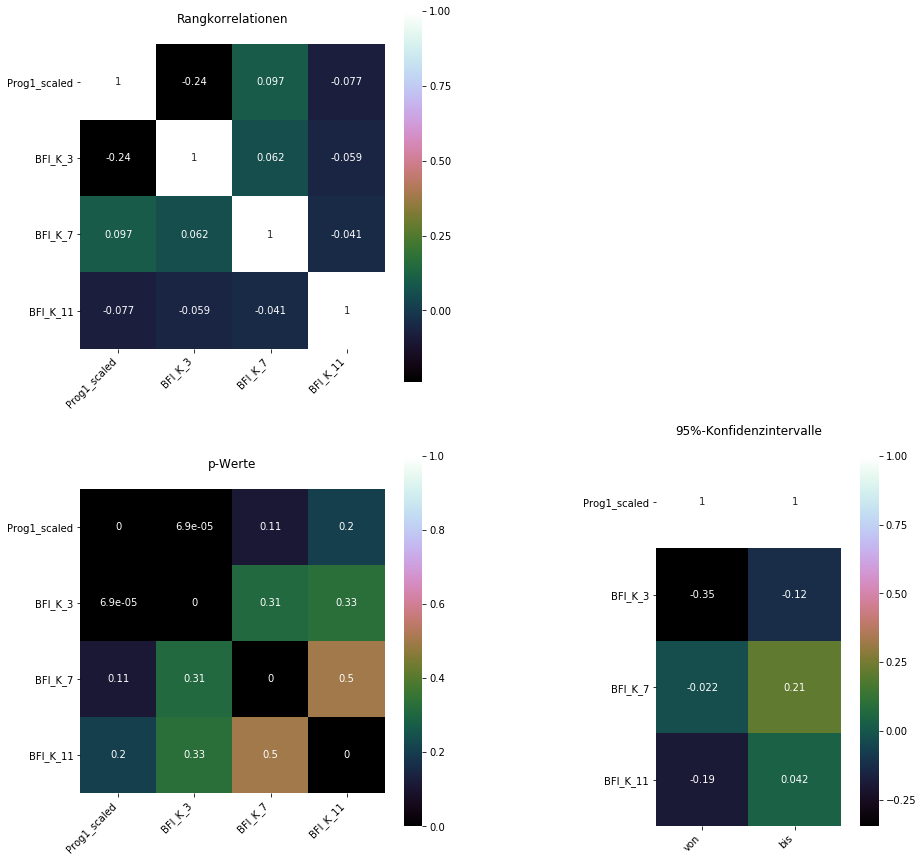

In [17]:
columns = ["BFI_K_3", "BFI_K_7", "BFI_K_11"]
corr_matrix, pvalues, intervals = display_sp(data,columns)

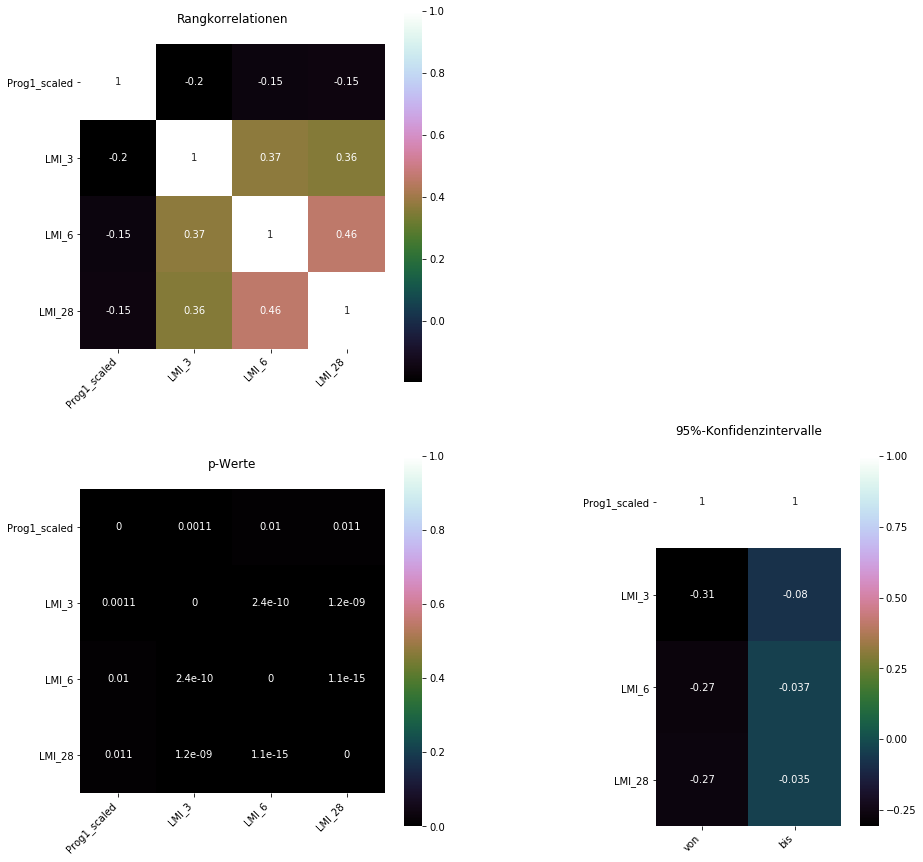

In [18]:
columns = [ "LMI_3", "LMI_6", "LMI_28"]
corr_matrix, pvalues, intervals = display_sp(data,columns)